# Stock Price Direction Prediction

## Table of Contents

- [Objective](#objective)
- [Setup](#setup)
- [Data Exploration](#data-exploration)
- [Feature Engineering](#feature-engineering)
- [Machine Learning Models](#machine-learning-models)
    - [Logistic Regression](#logistic-regression)
    - [Decision Tree](#decision-tree)
    - [Random Forest](#random-forest)
    - [Gradient Boosting Ensemble](#gradient-boosting-ensemble)
- [Deep Learning Model](#deep-learning-model)
- [Conclusion](#conclusion)

## Objective <a id='objective'></a>

The task is to predict the day price direction of [Amazon](https://www.amazon.com/) stock (AMZN).

To be profitable, it is *not* necessary to predict the correct price, but instead, the price **direction**.

The price direction is defined as whether the price will be higher or lower than the price is today.

- If the price direction is predicted as **higher**, then it may be prudent to **buy** stocks.
- However, if the price direction is predicted as **lower**, then **selling** stocks is a better decision.

Here, the target would be a binary classification whether the next day's closing price will be higher than the opening price.

There is data for the period from `1997` to `2020`. The data has been split into training (`1997-2016`), validation (`2016-2018`) and testing (`2018-2020`) periods.

## Setup <a id='setup'></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay

# Deep learning
from tensorflow.random import set_seed
from tensorflow.math import exp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

## Data Exploration <a id='data-exploration'></a>

In [2]:
# Read training data
df_train = pd.read_csv('data/raw/AMZN_train.csv')

In [3]:
# Shape of data
df_train.shape

(4781, 7)

In [4]:
# Information on DataFrame
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4781 non-null   object 
 1   Open       4781 non-null   float64
 2   High       4781 non-null   float64
 3   Low        4781 non-null   float64
 4   Close      4781 non-null   float64
 5   Adj Close  4781 non-null   float64
 6   Volume     4781 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 261.6+ KB


In [5]:
# Summary statistics of numerical columns in training data
df_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4781.000000,4781.000000,4781.000000,4781.000000,4781.000000,4.781000e+03
mean,127.619845,129.480122,125.697925,127.662449,127.662449,8.225935e+06
std,145.693083,147.132537,144.053633,145.677581,145.677581,7.810188e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,34.299999,34.849998,33.660000,34.310001,34.310001,4.200900e+06
50%,62.880001,64.750000,60.937500,62.750000,62.750000,6.200100e+06
75%,189.009995,191.600006,186.210007,189.029999,189.029999,9.239900e+06
max,717.380005,722.450012,711.510010,717.929993,717.929993,1.043292e+08


In [6]:
# Summary statistics of `Date` column
df_train['Date'].describe()

count           4781
unique          4781
top       1997-05-15
freq               1
Name: Date, dtype: object

In [7]:
# Get time range
df_train['Date'].min(), df_train['Date'].max()

('1997-05-15', '2016-05-13')

In [8]:
# Set figure size in default configuration parameters
plt.rcParams['figure.figsize'] = (12, 9)

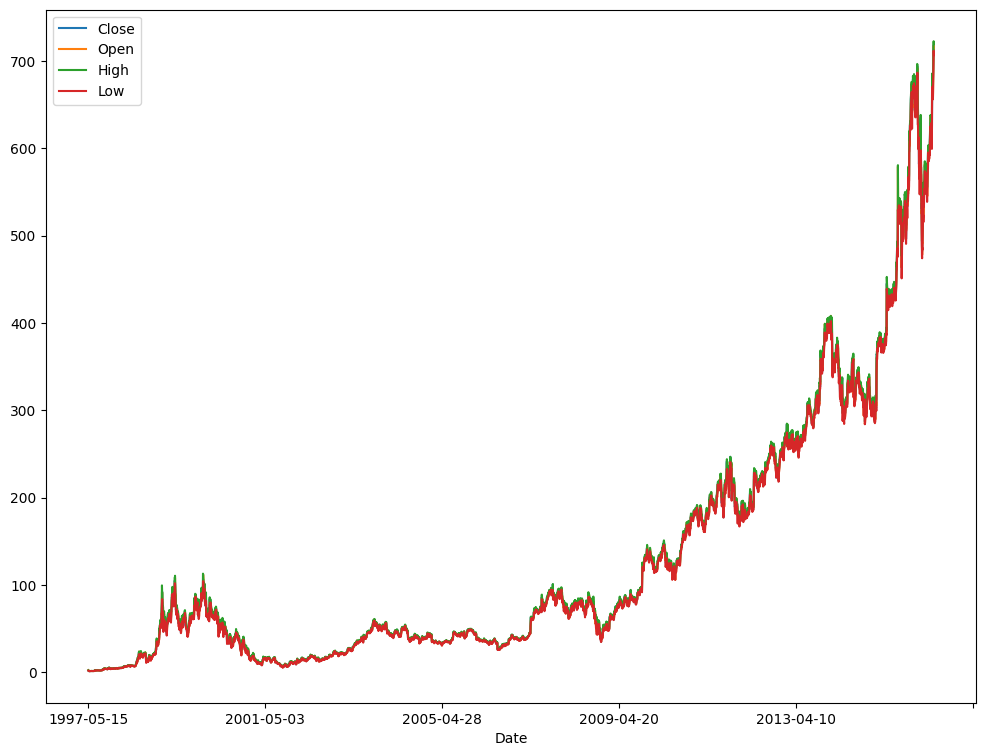

In [9]:
# Plot stock prices as a function of time
_ = df_train.plot(x='Date', y=['Close', 'Open', 'High', 'Low'])

The same analysis will be repeated for the validation and test sets to check for errors and ensure they follow a similar distribution.

A function can be defined to analyze a DataFrame.

In [10]:
# Define a function to analyze a DataFrame
def analyze(dataframe):
    """
    Run exploration analysis of DataFrame.
    """
    print(f'Shape: {dataframe.shape}\n')
    print(f'Columns: {dataframe.columns}\n')
    dataframe.info()
    print(f'\n{dataframe.describe()}\n')
    print(f'Time range: {dataframe.Date.min()} to {dataframe.Date.max()}\n')
    dataframe.plot(x='Date', y=['Close', 'Open', 'High', 'Low'])

In [11]:
# Read validation data
df_val = pd.read_csv('data/raw/AMZN_val.csv')

Shape: (503, 7)

Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       503 non-null    object 
 1   Open       503 non-null    float64
 2   High       503 non-null    float64
 3   Low        503 non-null    float64
 4   Close      503 non-null    float64
 5   Adj Close  503 non-null    float64
 6   Volume     503 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.6+ KB

              Open         High          Low        Close    Adj Close  \
count   503.000000   503.000000   503.000000   503.000000   503.000000   
mean    992.201292   999.898131   982.574513   991.828966   991.828966   
std     255.496588   259.220381   250.100614   254.885469   254.885469   
min     689.559998   696.820007   682.119995   691.359985   69

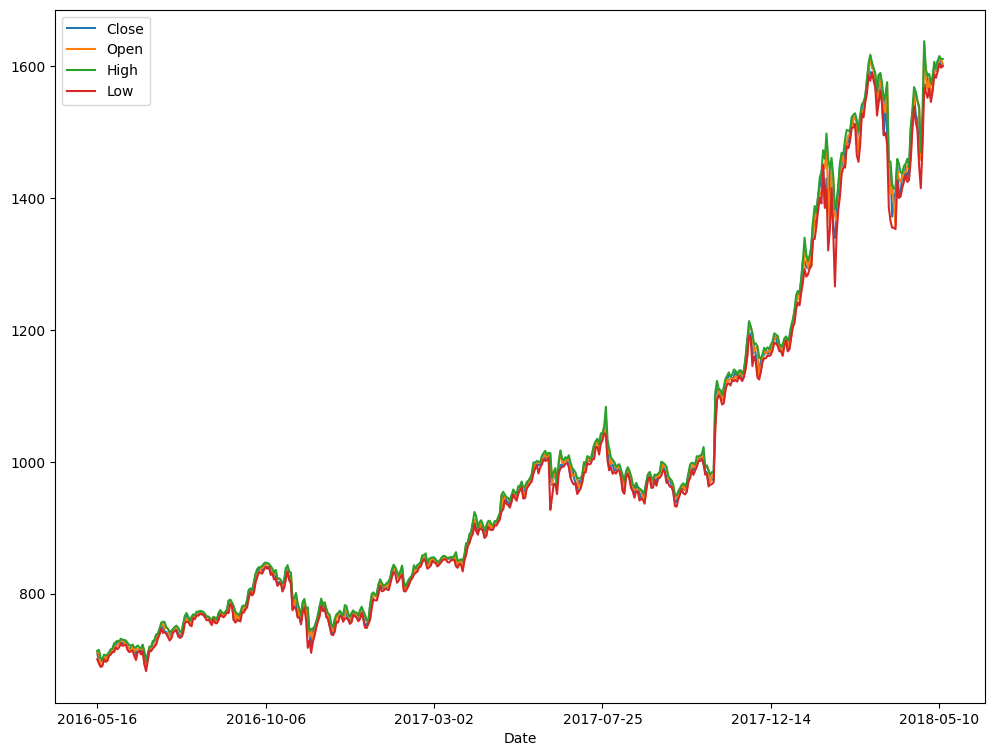

In [12]:
# Analyze validation data
analyze(df_val)

In [13]:
# Read test data
df_test = pd.read_csv('data/raw/AMZN_test.csv')

Shape: (504, 7)

Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       504 non-null    object 
 1   Open       504 non-null    float64
 2   High       504 non-null    float64
 3   Low        504 non-null    float64
 4   Close      504 non-null    float64
 5   Adj Close  504 non-null    float64
 6   Volume     504 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.7+ KB

              Open         High          Low        Close    Adj Close  \
count   504.000000   504.000000   504.000000   504.000000   504.000000   
mean   1823.927758  1843.069246  1803.067065  1824.040536  1824.040536   
std     178.129809   179.294163   177.457741   178.470078   178.470078   
min    1346.000000  1396.030029  1307.000000  1343.959961  134

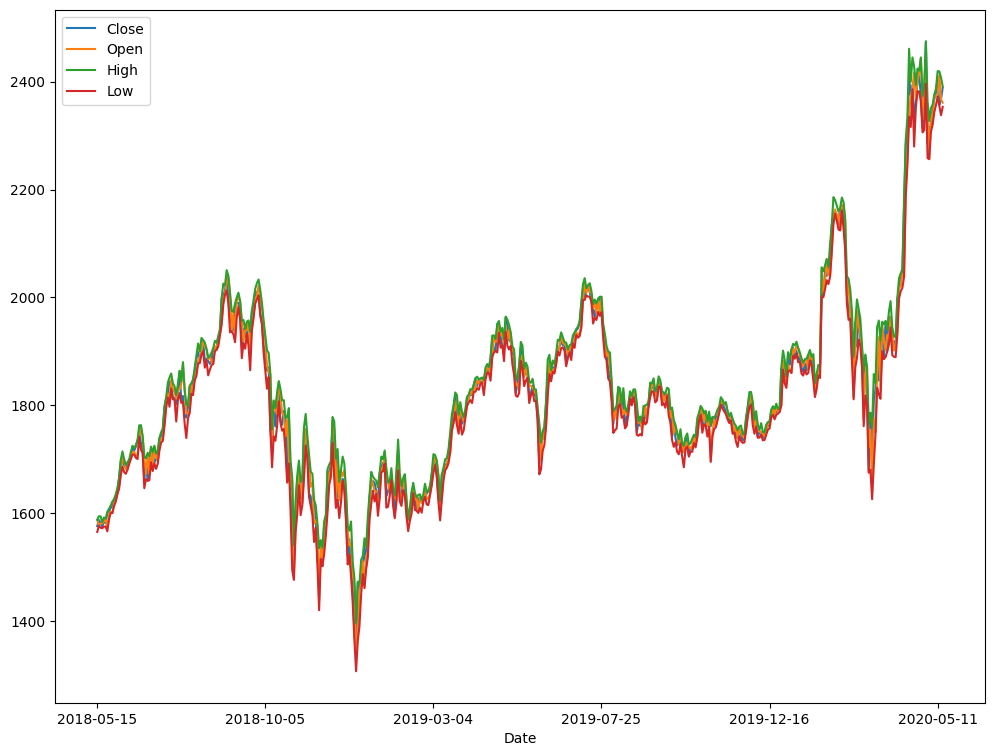

In [14]:
# Analyze test data
analyze(df_test)

The task is to predict if the next day's closing price with be higher than the opening price.

This information may be inferred by comparing the closing and opening prices one day in advance.

After sorting the data by `Date`, the pandas `shift` method with a period of minus one will shift the data from the next day back.

In [15]:
# Sort data by `Date` in ascending order
df_train = df_train.sort_values(by='Date')
df_val = df_val.sort_values(by='Date')
df_test = df_test.sort_values(by='Date')

In [16]:
# Create target column for training data
# Shift by a period of '-1' takes the next day's price direction for the current day
# Positive period will take days from past
df_train['Target'] = (df_train['Close'] > df_train['Open']).shift(periods=-1, fill_value=0).astype(int)

In [17]:
# Sample of training data
df_train.sample(n=10)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
959,2001-03-06,13.078125,14.000000,11.250000,11.875000,11.875000,23191500,1
3805,2012-06-27,225.009995,227.500000,223.300003,225.619995,225.619995,2799200,0
2750,2008-04-22,79.940002,79.940002,77.540001,79.599998,79.599998,7245000,1
2472,2007-03-15,38.099998,38.290001,37.549999,37.779999,37.779999,7265700,1
3102,2009-09-14,83.809998,84.570000,83.459999,83.860001,83.860001,3572000,0
2918,2008-12-18,53.000000,54.849998,51.200001,52.080002,52.080002,7518100,0
2632,2007-10-31,88.050003,89.599998,87.000000,89.150002,89.150002,7044800,0
4003,2013-04-15,271.079987,275.119995,267.100006,267.720001,267.720001,3326000,1
1267,2002-05-31,18.500000,18.889999,18.200001,18.230000,18.230000,5081400,0
165,1998-01-09,4.666667,4.666667,4.229167,4.260417,4.260417,6643200,1


In [18]:
# Get distribution of `Target` column in training data
df_train['Target'].value_counts()

Target
1    2392
0    2389
Name: count, dtype: int64

In [19]:
# Print results
print(f'There are {df_train.Target.value_counts()[1]} days when the closing price is higher than the opening price.')
print(f'There are {df_train.Target.value_counts()[0]} days when the closing price is lower than the opening price.')

There are 2392 days when the closing price is higher than the opening price.
There are 2389 days when the closing price is lower than the opening price.


In [20]:
# Create target column for validation data
# Shift by a period of '-1' takes the next day's price direction for the current day
# Positive period will take days from past
df_val['Target'] = (df_val['Close'] > df_val['Open']).shift(periods=-1, fill_value=0).astype(int)

In [21]:
# Get distribution of `Target` column in validation data
df_val['Target'].value_counts()

Target
0    255
1    248
Name: count, dtype: int64

In [22]:
# Create target column for test data
# Shift by a period of '-1' takes the next day's price direction for the current day
# Positive period will take days from past
df_test['Target'] = (df_test['Close'] > df_test['Open']).shift(periods=-1, fill_value=0).astype(int)

In [23]:
# Get distribution of `Target` column in test data
df_test['Target'].value_counts()

Target
1    255
0    249
Name: count, dtype: int64

## Feature Engineering <a id='feature-engineering'></a>

Stock prices are time dependent so the next day's price is influenced by the previous days' prices. To capture trends or the magnitude of price changes, values from the last `n` days will be considered.

A simple solution is to calculate a moving average. The pandas library simplifies this with the `rolling` method, providing an interface for sliding window calculations. In this case, the 3-day nd 7-day moving averages will be computed, then added as features to the data.

The `rolling` method provides valid results only if the data is sorted by date.

In [24]:
# Define function to add moving average column to DataFrame
def add_moving_average(df, column_name, window_size):
    df[column_name] = (df['Close'] - df['Open']).rolling(window=window_size, min_periods=1).mean()

In [25]:
# Create 3-day moving average column in all data sets
dataframes = [df_train, df_val, df_test]
column_name = 'Moving_Average_3'
window_size = 3

for df in dataframes:
    add_moving_average(df, column_name, window_size)

In [26]:
# Create 7-day moving average column in all data sets
column_name = 'Moving_Average_7'
window_size = 7

for df in dataframes:
    add_moving_average(df, column_name, window_size)

In [27]:
# Define function to add today's direction column to DataFrame
def add_today_direction(df):
    df['Today_Direction'] = df['Close'] - df['Open']

In [28]:
# Create today's direction column in all data sets
for df in dataframes:
    add_today_direction(df)

In [29]:
# Define function to add price range column to DataFrame
def add_price_range(df):
    df['Price_Range'] = df['High'] - df['Low']

In [30]:
# Create price range column in all data sets
for df in dataframes:
    add_price_range(df)

In [31]:
# Sample of training data with new features added
df_train.sample(n=10, random_state=42)

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Moving_Average_3,Moving_Average_7,Today_Direction,Price_Range
2895,2008-11-14,43.610001,44.500000,41.500000,41.750000,41.750000,11949700,0,-0.253335,-0.601429,-1.860001,3.000000
4430,2014-12-22,301.940002,307.359985,301.940002,306.540009,306.540009,4003800,0,0.436666,-0.705710,4.600007,5.419983
3618,2011-09-29,234.169998,234.300003,216.289993,222.440002,222.440002,9378500,0,-6.126663,-2.434283,-11.729996,18.010010
763,2000-05-24,46.437500,49.750000,40.437500,48.562500,48.562500,11666600,0,-0.937500,-0.580357,2.125000,9.312500
4392,2014-10-28,289.760010,298.000000,289.760010,295.589996,295.589996,5572600,0,4.253326,2.681423,5.829986,8.239990
4657,2015-11-16,640.919983,649.989990,622.289978,647.809998,647.809998,7435900,0,-7.243347,-0.264299,6.890015,27.700012
4008,2013-04-22,259.350006,264.600006,258.029999,263.549988,263.549988,2119100,1,-0.343333,-0.287140,4.199982,6.570007
555,1999-07-29,51.187500,52.187500,50.000000,50.781250,50.781250,18748000,0,-0.841146,-0.713170,-0.406250,2.187500
2754,2008-04-28,80.639999,82.500000,80.120003,81.970001,81.970001,10991900,0,1.453336,1.212857,1.330002,2.379997
33,1997-07-02,1.515625,1.593750,1.510417,1.588542,1.588542,3882000,1,0.026042,0.004464,0.072917,0.083333


## Machine Learning Models <a id='machine-learning-models'></a>

In [32]:
# Set feature columns for models as list
X_cols = df_train.select_dtypes(include='number').drop(columns='Target').columns.tolist()

# Set target column to predict
y_col = 'Target'

In [33]:
# Training data
X_train = df_train[X_cols]
y_train = df_train[y_col]

# Validation data
X_val = df_val[X_cols]
y_val = df_val[y_col]

# Test data
X_test = df_test[X_cols]
y_test = df_test[y_col]

In [34]:
# Set random seed for reproducible results
random_seed = 42

### Logistic Regression <a id='logistic-regression'></a>

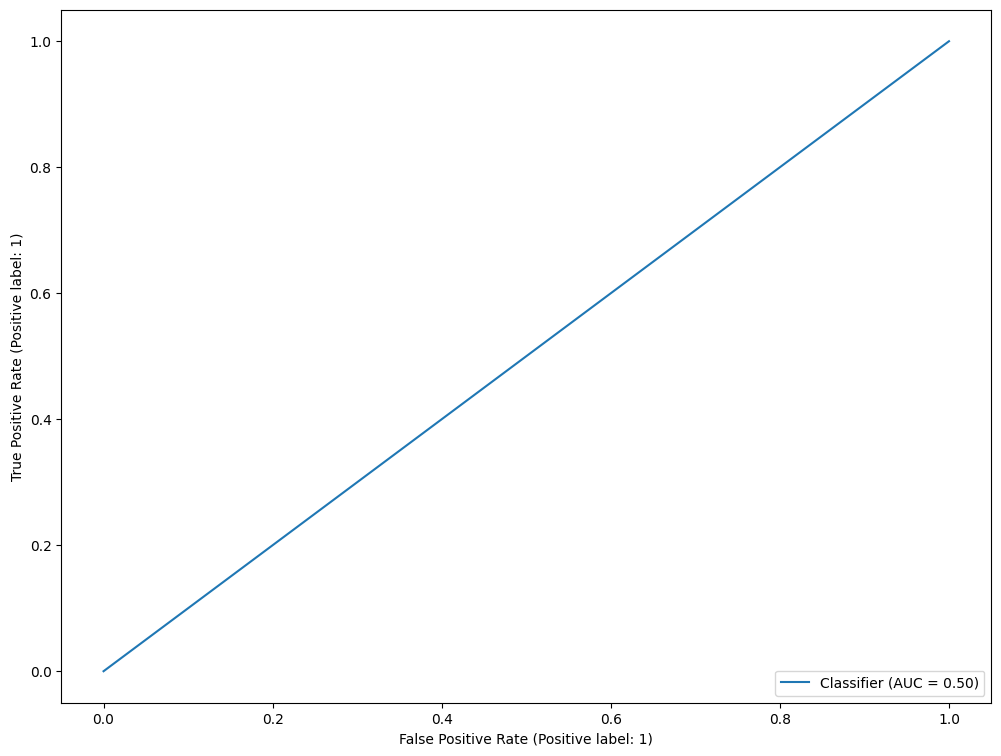

In [35]:
# Initialize model
lr = LogisticRegression()

# Fit model to training data
lr.fit(X=X_train, y=y_train)

# Make predictions on validation data
y_pred = lr.predict(X=X_val)

# ROC curve visualization
_ = RocCurveDisplay.from_predictions(y_true=y_val, y_pred=y_pred)

Logistic regression is not a suitable solution because the Area Under the Curve (AUC) is 0.5 so the classifier is not better or worse than a random estimate.

Here, the problem is complex so an AUC over 0.5 would be sufficient for this task.

### Decision Tree <a id='decision-tree'></a>

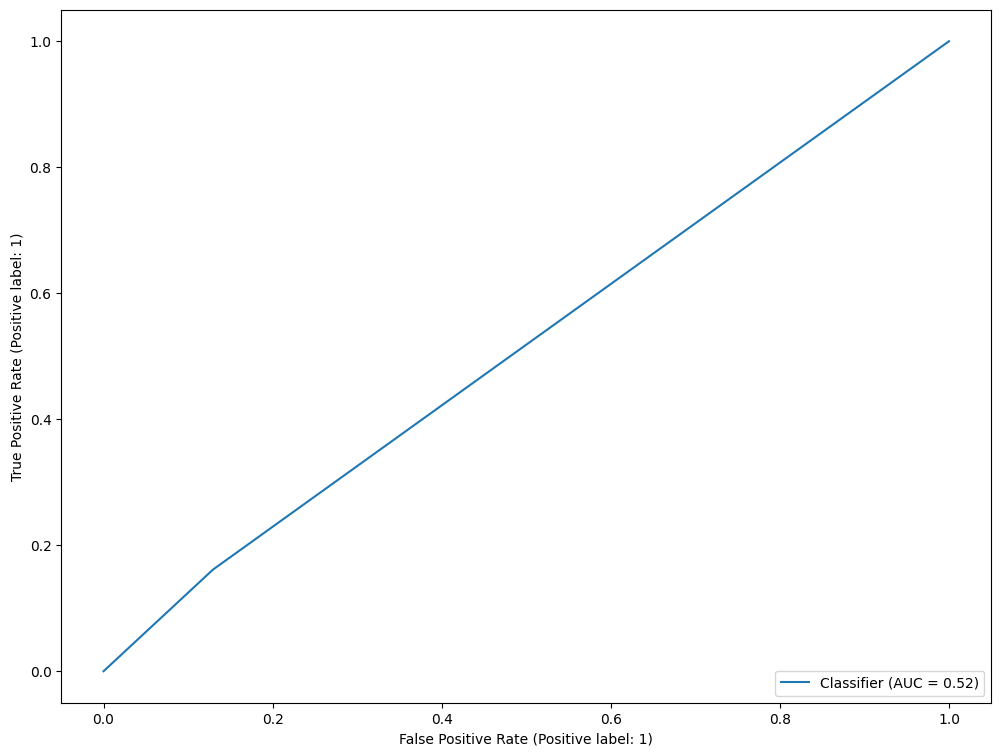

In [36]:
# Initialize model
dt = DecisionTreeClassifier(random_state=random_seed)

# Fit model to training data
dt.fit(X=X_train, y=y_train)

# Make predictions on validation data
y_pred = dt.predict(X=X_val)

# ROC curve visualization
_ = RocCurveDisplay.from_predictions(y_true=y_val, y_pred=y_pred)

The decision tree model outperforms the logistic regression model by 0.02, and its AUC is above 0.5.

### Random Forest <a id='random-forest'></a>

Random Forest is an ensemble model that builds multiple decision trees, each with a different and random sub-set of features.

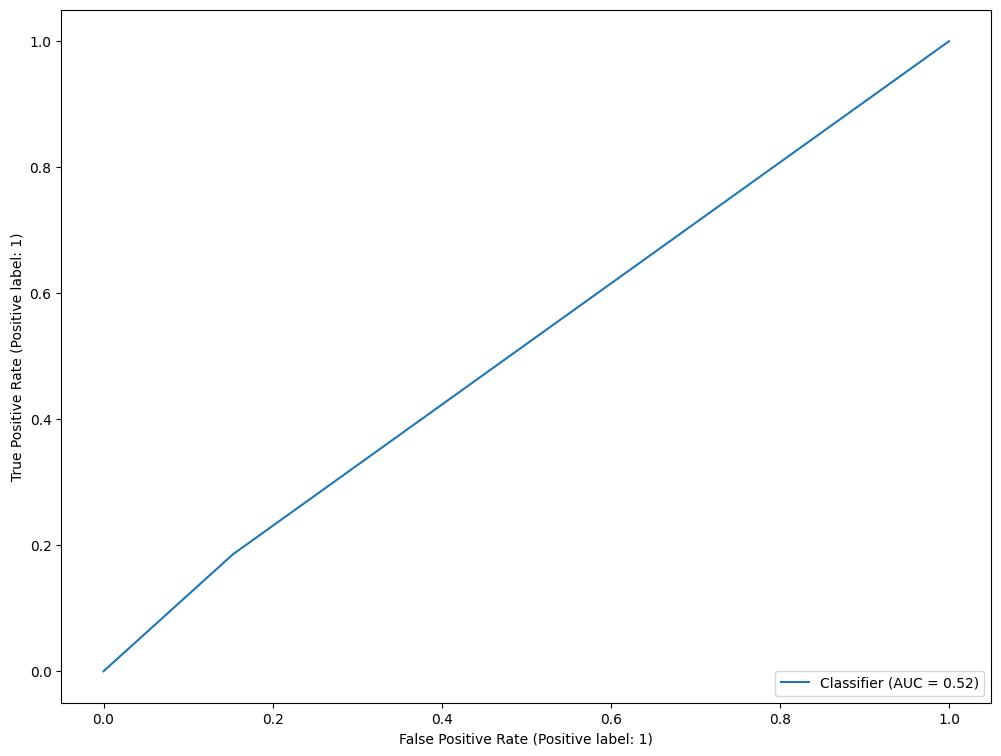

In [37]:
# Initialize model
rf = RandomForestClassifier(random_state=random_seed)

# Fit model to training data
rf.fit(X=X_train, y=y_train)

# Make predictions on validation data
y_pred = rf.predict(X=X_val)

# ROC curve visualization
_ = RocCurveDisplay.from_predictions(y_true=y_val, y_pred=y_pred)

The Random Forest model shows the same performance as the Decision Tree model.

### Gradient Boosting Ensemble <a id='gradient-boosting-ensemble'></a>

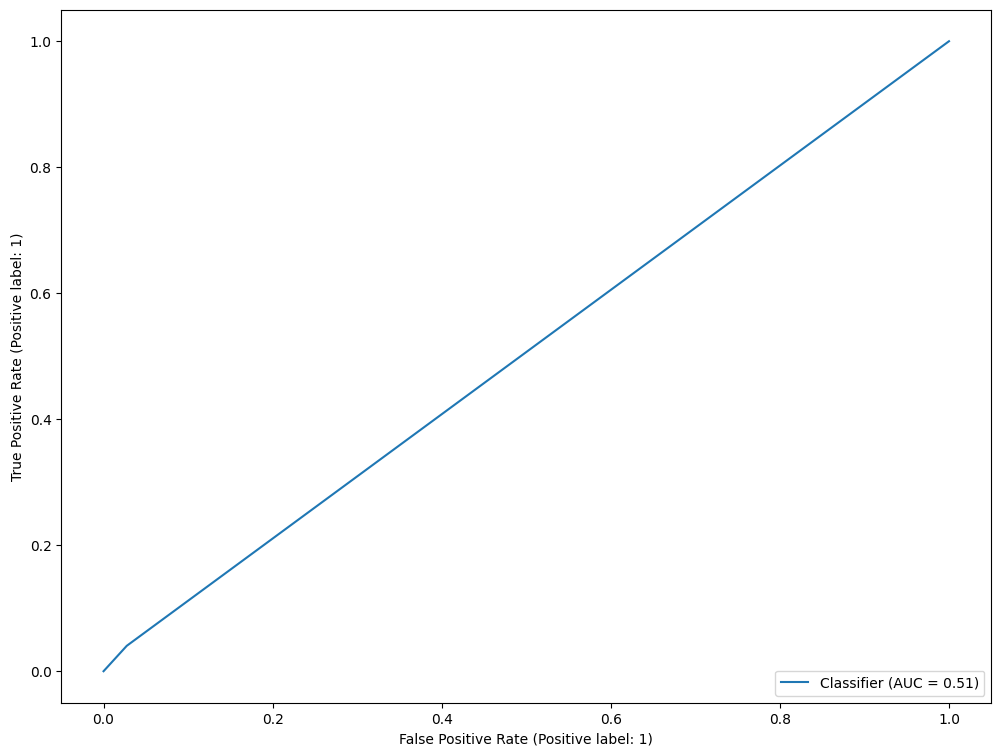

In [38]:
# Initialize model
gb = GradientBoostingClassifier(random_state=random_seed)

# Fit model to training data
gb.fit(X=X_train, y=y_train)

# Make predictions on validation data
y_pred = gb.predict(X=X_val)

# ROC curve visualization
_ = RocCurveDisplay.from_predictions(y_true=y_val, y_pred=y_pred)

The Gradient Boosting Ensemble model does not outperform the Random Forest and Decision Tree models.

## Deep Learning Model <a id='deep-learning-model'></a>

In [39]:
# Set seed for reproducibility of results
set_seed(random_seed)

In [40]:
# Build model
model = Sequential([
    Normalization(axis=-1),
    Dense(units=10, input_shape=[X_train.shape[1], ], activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'),
    Dropout(rate=0.2, seed=random_seed),
    Dense(units=5, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'),
    Dense(units=1, activation='sigmoid', kernel_initializer='random_normal', bias_initializer='zeros')
])

2023-12-07 16:18:25.264403: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-12-07 16:18:25.264419: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-07 16:18:25.264423: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-07 16:18:25.264449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 16:18:25.264468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [41]:
# Compile model
# Configure model loss function, weight optimizer, and metrics
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['AUC']
)

The model will be trained for 50 epochs, and keep track of its loss and AUC values during each epoch.

To prevent overfitting, two callbacks will be implemented:

1. learning rate scheduler
2. early stopping callback

In [42]:
# Define function for learning rate scheduler
def learning_rate_scheduler(epoch, learning_rate):
    """
    Learning rate decay callback.
    """
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * exp(-0.01)

In [43]:
# Set learning rate callback
learning_rate_callback = LearningRateScheduler(learning_rate_scheduler)

# Set early stopping callback
early_stopping_callback = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

In [44]:
# Fit model to training data
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
    callbacks=[early_stopping_callback, learning_rate_callback]
)

Epoch 1/50


2023-12-07 16:18:25.641041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 2s 10ms/step - loss: 572.9293 - auc: 0.4938 - val_loss: 31.9323 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/50
150/150 [==============================] - 1s 8ms/step - loss: 51.0579 - auc: 0.5031 - val_loss: 30.0300 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/50
150/150 [==============================] - 1s 8ms/step - loss: 21.0442 - auc: 0.4952 - val_loss: 2.0847 - val_auc: 0.4863 - lr: 0.0010
Epoch 4/50
150/150 [==============================] - 1s 7ms/step - loss: 16.1781 - auc: 0.4929 - val_loss: 8.3323 - val_auc: 0.5000 - lr: 0.0010
Epoch 5/50
150/150 [==============================] - 1s 8ms/step - loss: 15.8105 - auc: 0.4947 - val_loss: 1.8903 - val_auc: 0.5087 - lr: 0.0010
Epoch 6/50
150/150 [==============================] - 1s 8ms/step - loss: 11.8830 - auc: 0.4858 - val_loss: 7.9315 - val_auc: 0.5000 - lr: 9.9005e-04
Epoch 7/50
150/150 [==============================] - 1s 8ms/step - loss: 28.4828 - auc: 0.5010 - val_loss: 5.4934 - val_auc: 0

Here, the training and the validation AUC are close to 0.5 so the deep learning model's performance is similar to the logistic regression model.

In [45]:
# Show summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 10)                21        
 on)                                                             
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 192 (772.00 Byte)
Trainable params: 171 (684.00 Byte)
Non-trainable params: 21 (88.00 Byte)
________________

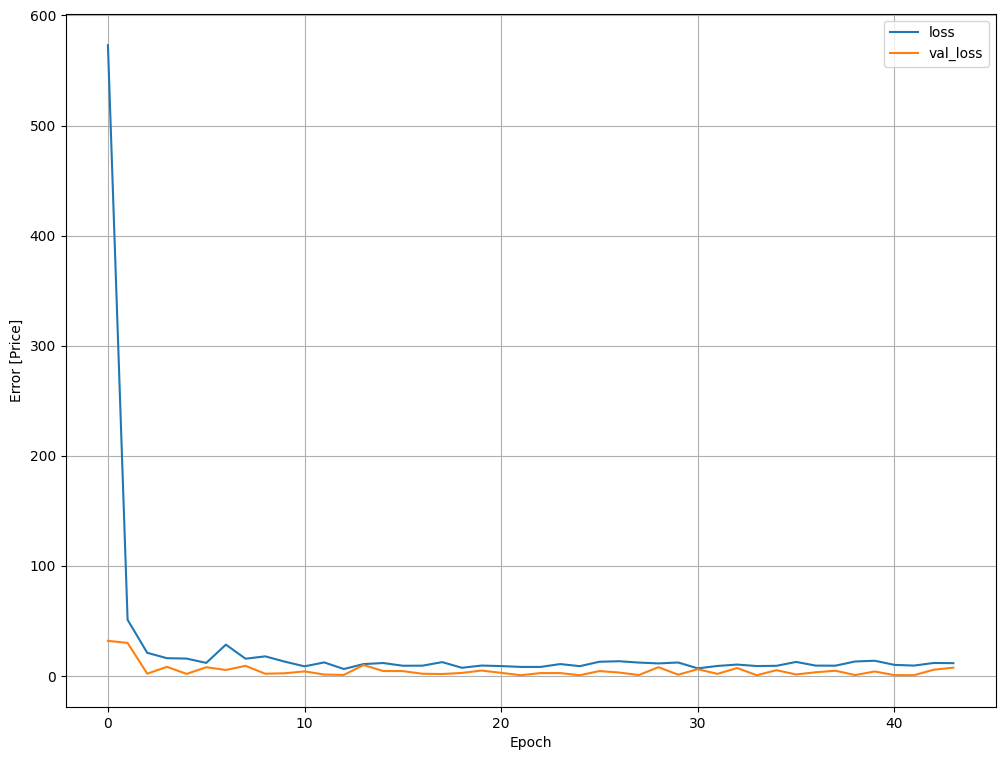

In [46]:
# Plot training and validation loss as a function of epoch
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)

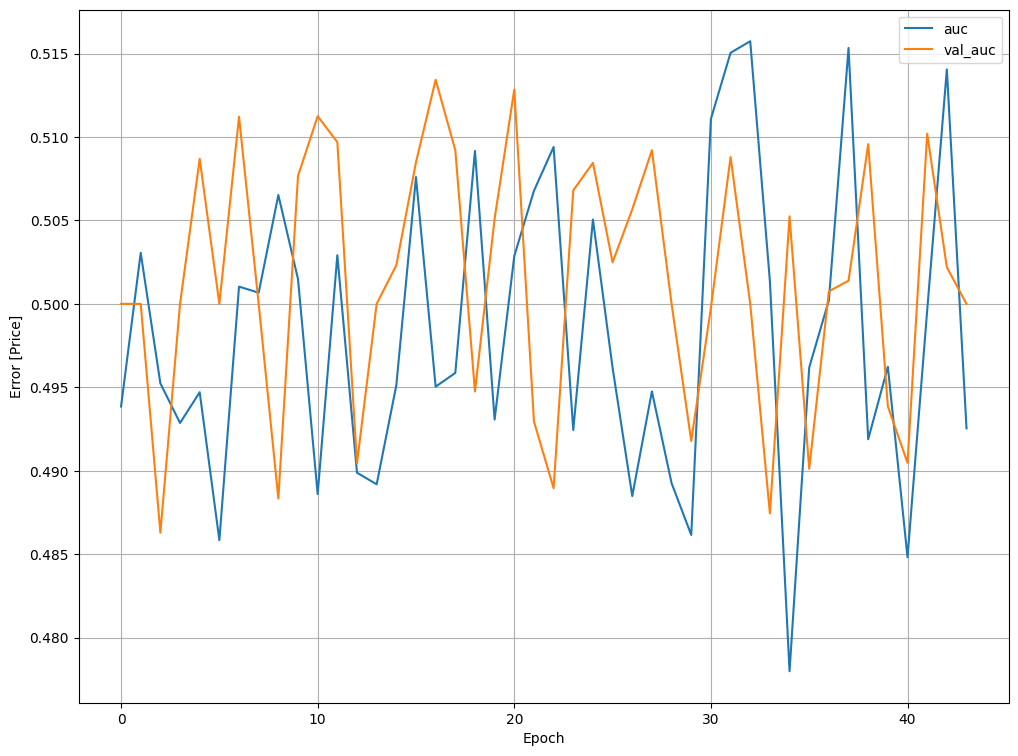

In [47]:
# Plot training and validation AUC values as a function of epoch
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)

## Conclusion <a id='conclusion'></a>

The decision tree and random forest classifiers provided the best AUC scores on the validation set. The decision tree model is a simpler solution so it may be implemented as a solution.

To simulate a production environment, the test set is withheld until now.

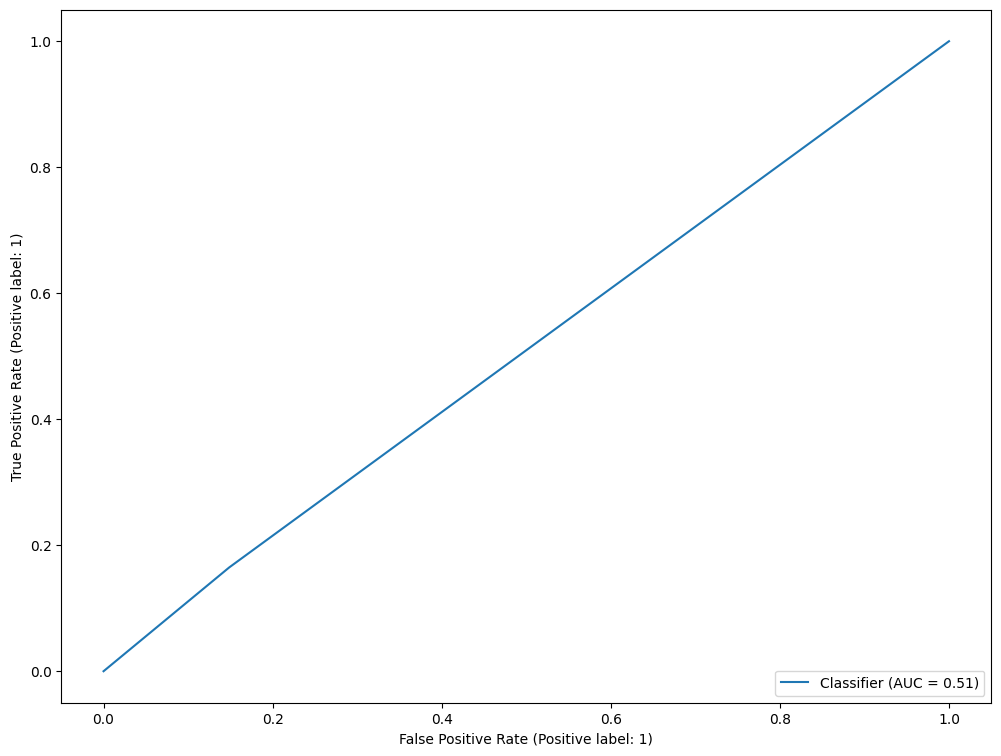

In [48]:
# Make predictions with Decision Tree classifier on test data
y_pred = dt.predict(X=X_test)

# ROC curve visualization
_ = RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

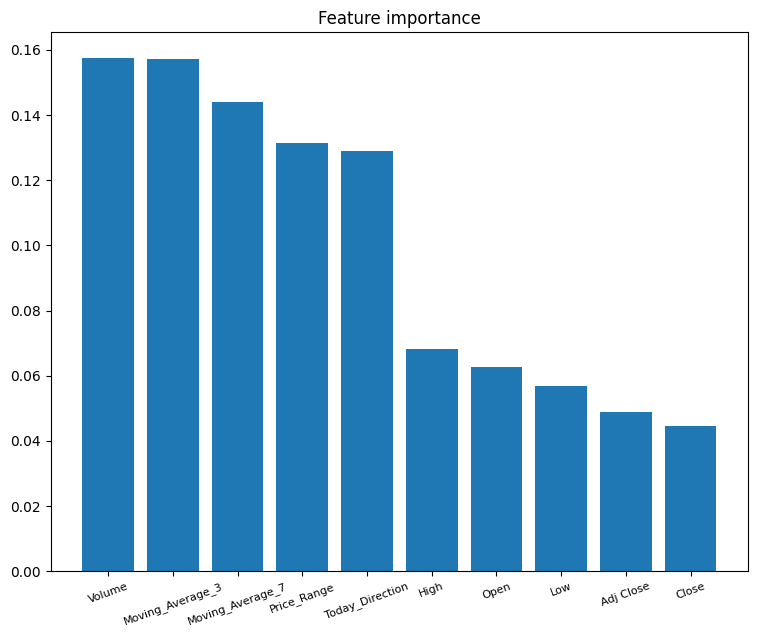

In [49]:
# Plot feature importances with respect to predictive performance of model

# Calculate feature importances
importances = dt.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names to match sorted feature importances
names = [df_train[X_cols].columns[i] for i in indices]

# Plot bar chart
_ = plt.figure(figsize=(9, 7))
plt.bar(names, importances[indices])
_ = plt.title('Feature importance')
_ = plt.xticks(rotation=20, fontsize=8)

This notebook was inspired by the [Prediction of Stock Price Direction](https://platform.stratascratch.com/data-projects/prediction-stock-price-direction) data project on [StrataScratch](https://www.stratascratch.com/).